In [1]:
%load_ext autoreload
%autoreload 2

# 2018-11-08 How the wrap-up script works
Tout est compilé dans Spiking_LGN.py maintenant, il suffit de lui passer les arguments sur toutes les fonctions et il renvoie des courants. 

! La sauvegarde n'est pas incluse, je la laisse en manuelle dans les scripts, c'est plus simple

## 11/09 : Sampling rate ajouté pour accélerer les calculs, attention au plotting, mais tout est prévu pour ne pas perdre d'informations sinon

In [2]:
import numpy as np
import Spiking_LGN as SpiLGN

In [3]:
#first we import the video
video = np.load('./LifeOfBrian_29.97FPS.npy')
video = np.swapaxes(video, 0, -1)
video = np.swapaxes(video, 0, 1)

In [4]:
help(SpiLGN.input_to_currents) #documentation for every function

Help on function input_to_currents in module Spiking_LGN:

input_to_currents(video, FPS, total_time, distrib_size, safeguard_offset, random_shift, grid_res, N_theta, B_theta, sf_0, B_sf, on_thresh, off_thresh, filter_size, filter_res, sampling_rate, n_jobs, backend, mt_verbose, gabors_params=None, verbose=True)
    Main method, transforms a numpy array input into currents that can be used
    by a spiking neuron simulator (optimized for Nest with PyNN)
    
    Args :
        > Input arguments <
        video : the numpy array input, a video of shape H x W x frames
                the format is for plt.imshow convenience, careful about the H x W order 
        FPS : video's frame per second
        total_time : simulation total time, should you want it shorter than video's length
    
        > Gabor parameters <
        gabors_params : if set to None, the default parameter dictionnary is used
    
        > Generating gabors centers and filters coordinates <
        distrib_size : the

In [5]:
# then we run it into the method, careful here N_theta = 4
output_currents = SpiLGN.input_to_currents(video=video, FPS=29.97, total_time=1000,
                                           distrib_size=8, safeguard_offset=5, random_shift=1, grid_res=3,
                                           N_theta=4, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=10)

Video shape (36, 64, 640)
Frames per second: 29.97
Frame duration at 29.97 FPS: 33.37 ms
Video length inferred from fps: 23 s
FPS conversion sanity check passed !

Stimuli shape (36, 64, 1000)

Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Done ! Generating currents from filters ..


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min finished


In [6]:
print('Output shape', np.asarray(output_currents).shape)
print('=(Thetas, Gabors, ON/OFF)')

Output shape (4, 21, 2)
=(Thetas, Gabors, ON/OFF)


In [7]:
#We show the second Theta (here pi/4) and third gabor (i.e. simple cell)
theta_display = 1
gabor_display = 3
on_st_levels = output_currents[theta_display][gabor_display][0]
off_st_levels = output_currents[theta_display][gabor_display][1]

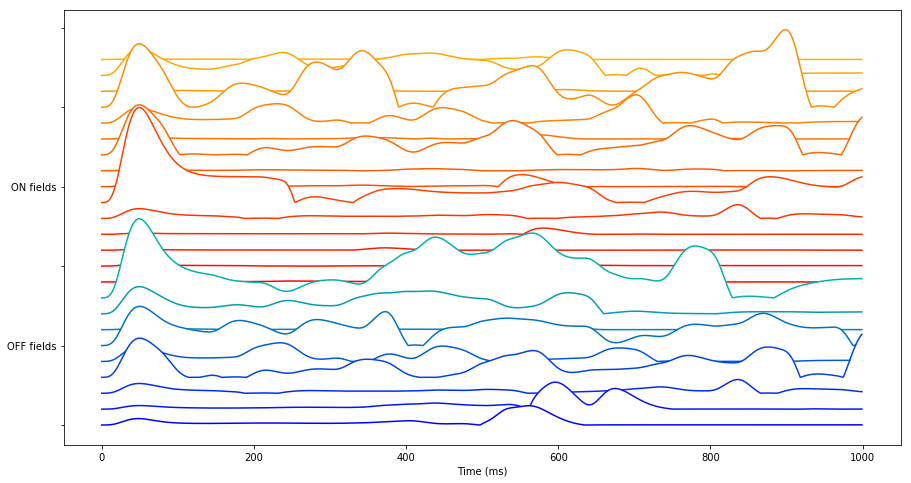

In [8]:
import matplotlib.pyplot as plt
chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('white')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 25

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='white',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])
ax.set_xlabel('Time (ms)')
plt.savefig('./figs/2018_11_08_Script_output_white.pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 

In [9]:
#Now we save the currents, in a numpy compressed array to save space (2.5x less size)
#tradeoff : saving twice as slow
import datetime

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")   
np.savez_compressed('./output/%s'%strtime, output_currents)

In [10]:
#the loading method is a bit different as the npz can dump multiple arrays
load_npz = np.load('./output/%s.npz'%strtime)
load_arr = load_npz['arr_0.npy'] #won't contain more than one array normally

# If we want to get the V1 RF coordinates :

Text(0.5,1,'Image fausse, pas d aleatoire, refaire')

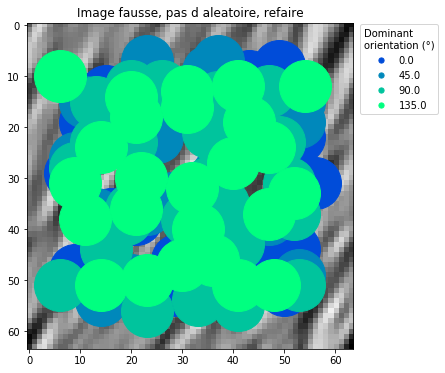

In [18]:
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
video.shape

coor = SpiLGN.generate_centers_coordinates(
        distrib_size=10, safeguard_offset = 12, random_shift = 1, video=video)

colors = plt.cm.winter(np.linspace(.3, 1,4))

fig = plt.figure(figsize = (8,6))
randomizer = 5
for i,thetas in enumerate(load_arr):
    plt.scatter(coor[0]+np.random.randint(-randomizer,randomizer, coor[0].shape),
                coor[1]+np.random.randint(-randomizer,randomizer, coor[0].shape),
                s = 52**2,edgecolors = None,
                facecolor = colors[i],
               alpha = 1, 
               label = i*(np.pi/4)*180/np.pi)


plt.imshow(video[:,:,0], cmap = plt.cm.binary)
plt.legend(loc = (1.02,.72), markerscale = .1, title = 'Dominant\norientation (°)')
plt.title('Image fausse, pas d aleatoire, refaire')